# Self-holography (Jishnu cal)

In [31]:
import pylab as plt

from ska_ost_low_uv.io import hdf5_to_uvx
from ska_ost_low_uv.postx import ApertureArray
from ska_ost_low_uv.utils import get_test_data

### Load example data

In [2]:
uvx = hdf5_to_uvx(get_test_data('s8-6/correlation_burst_204_20240701_65074_0.hdf5'), telescope_name='s8-6')
aa = ApertureArray(uvx)

2025-08-28 09:56:44.650 | INFO     | ska_ost_low_uv.io.metadata:load_observation_metadata:68 - Using internal config s8-6
2025-08-28 09:56:44.988 | INFO     | ska_ost_low_uv.datamodel.uvx:create_visibility_array:265 - Conjugating data
2025-08-28 09:56:44.991 | INFO     | ska_ost_low_uv.datamodel.uvx:create_visibility_array:269 - Transposing data
2025-08-28 09:56:44.994 | WARNING  | ska_ost_low_uv.io.to_uvx:hdf5_to_uvx:168 - Could not find expected keys in observation_info
2025-08-28 09:56:44.994 | WARNING  | ska_ost_low_uv.io.to_uvx:hdf5_to_uvx:170 - <KeysViewHDF5 []>


In [3]:
aa.calibration.holography.help()

<Aperture Array module: holography>

A class version of the above jishnu-cal holography routines.

Provides the following methods:
    help() - Print help for this class module.
    plot_aperture() - Plot aperture illumnation for given polarization index.
    plot_aperture_xy() - Plot aperture illumnation function magnitude and phase, both polarizations.
    plot_farfield_beam_pattern() - Plot the far-field beam power pattern, 2D cuts.
    plot_phasecal_iterations() - Plot the iterative phase corrections applied in phasecal.
    report_flagged_antennas() - Find antennas that have been flagged during phase calibration.
    run_jishnucal() - Iteratively apply Jishnu Cal phase calibration, then compute magnitude calibraiton.
    run_phasecal() - Iteratively apply Jishnu Cal phase calibration.
    run_selfholo() - Calibrate aperture array data using self-holography.
    set_cal_src() - Set/change calibration source.


## Run self-holography

Self holography assumes that the sky is dominated by a bright point source (e.g. the Sun). To use it, you first need to run `set_cal_src()` with a sky coordinate for the calibrator.

In [4]:
sun = aa.coords.get_sun()

aa.calibration.holography.set_cal_src(aa.viewer.skycat['GC'])
holo_dict = aa.calibration.holography.run_selfholo()

print(holo_dict.keys())

2025-08-28 09:56:45.177 | INFO     | ska_ost_low_uv.postx.calibration.holography:jishnu_selfholo:236 - Generating vis matrix: data


dict_keys(['beam_corr', 'aperture_img', 'meas_corr', 'lmn_grid', 'vis_matrix', 'aperture_size', 'n_pix', 'oversample_factor'])


### Plot self-holography results

Self-holography is useful for identifying dodgy antennas by inspecting the aperture illumination:

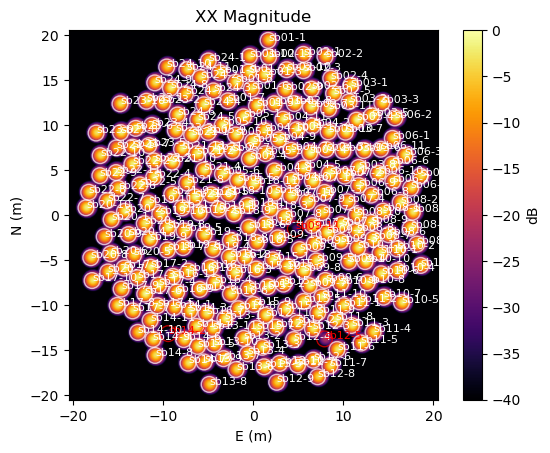

In [5]:
aa.calibration.holography.plot_aperture(annotate=True)

We can also plot the corresponding farfield beam pattern

/Users/daniel.price/Data/ska-ost-low-uv/src/ska_ost_low_uv/postx/calibration/holography.py:608: RuntimeWarning: invalid value encountered in arccos
  theta = np.rad2deg(np.arccos(holo_dict['lmn_grid'][0, :, 0])) - 90


(-50.0, 1.0)

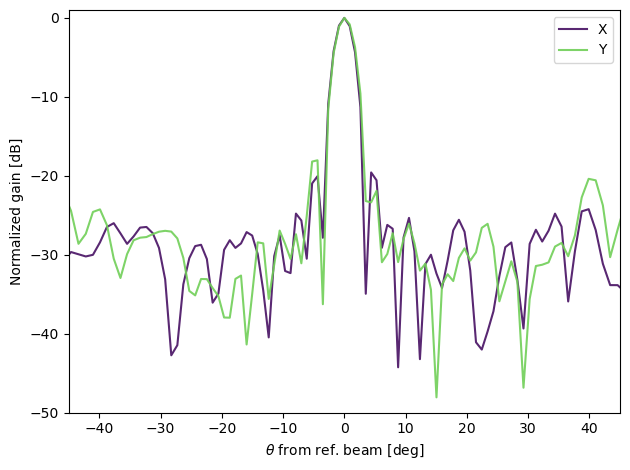

In [6]:
aa.calibration.holography.plot_farfield_beam_pattern()
plt.xlim(-45, 45)
plt.ylim(-50, 1)

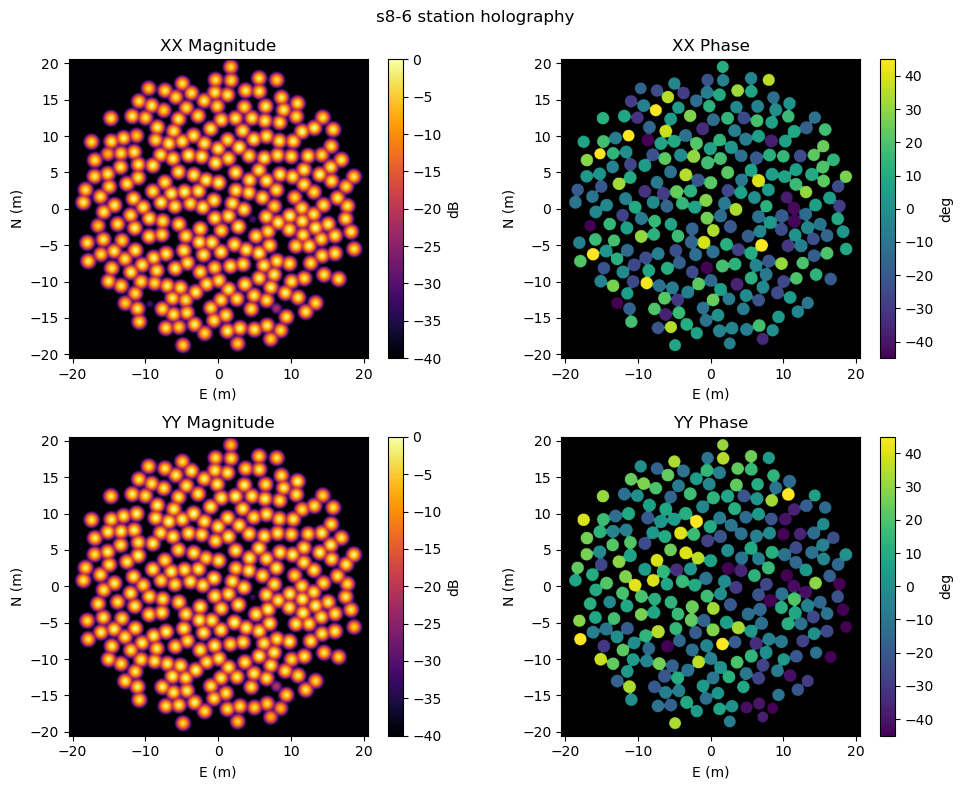

In [7]:
aa.calibration.holography.plot_aperture_xy(phs_range=(-45, 45))

## Generating a calibration solution

Calibration is run using the `run_jishnucal`, which is based on J. Thekkeppattu et al. (2024)
https://ui.adsabs.harvard.edu/abs/2024RaSc...5907847T/abstract

Jishnu cal computes gain and phase calibration via self-holography on visibility data.
A post-correlation beam is formed toward a strong calibrator source, then cross-correlated against a grid of beams (also formed from visibilities).

The resulting 'beam correlation' is a measure of the far-field electric field pattern. A Fourier transform of the electric field pattern yields the 'aperture illumination', which shows the gain and phase of each antenna.

For a phase-only calibration, you can run `run_phasecal` instead. Note the calibration routines do not generate the aperture illumination plots (you need to run `run_selfholo()`).


In [8]:
cal_phs = aa.calibration.holography.run_phasecal()
cal = aa.calibration.holography.run_jishnucal()

2025-08-28 09:56:48.926 | INFO     | ska_ost_low_uv.postx.calibration.holography:jishnu_phasecal:331 - Iter 26: Iteration phase std minima reached, breaking
2025-08-28 09:56:48.978 | INFO     | ska_ost_low_uv.postx.calibration.holography:jishnu_phasecal:331 - Iter 26: Iteration phase std minima reached, breaking


In [9]:
cal.report_flagged_antennas()

{'x': {'idx': array([ 87, 113, 132, 156, 219, 230]),
  'name': array(['sb09-11', 'sb12-5', 'sb14-2', 'sb14-10', 'sb20-9', 'sb23-4'],
        dtype=object)},
 'y': {'idx': array([ 87, 113, 132]),
  'name': array(['sb09-11', 'sb12-5', 'sb14-2'], dtype=object)}}

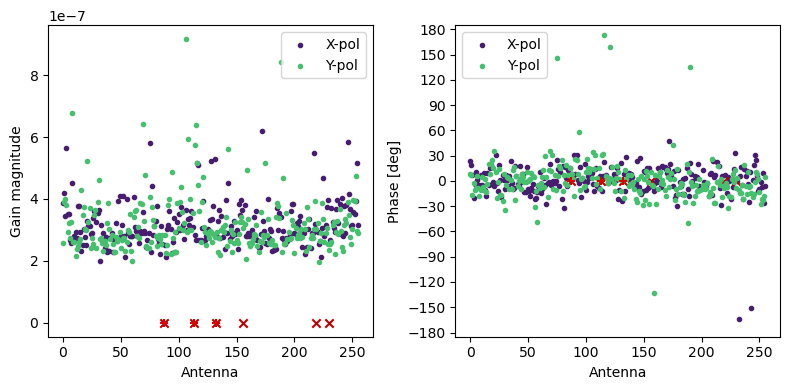

In [10]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
cal.plot_gains(plot_type='mag')
plt.subplot(1, 2, 2)
cal.plot_gains(plot_type='phs')
plt.tight_layout()

## Apply the calibration

The calibration is applied by the `set_cal()` method on the `ApertureArray` object.

In [11]:
aa.set_cal(cal)

In [12]:
holo_dict2 = aa.calibration.holography.run_selfholo(vis='cal')

2025-08-28 09:56:50.706 | INFO     | ska_ost_low_uv.postx.calibration.holography:jishnu_selfholo:236 - Generating vis matrix: cal


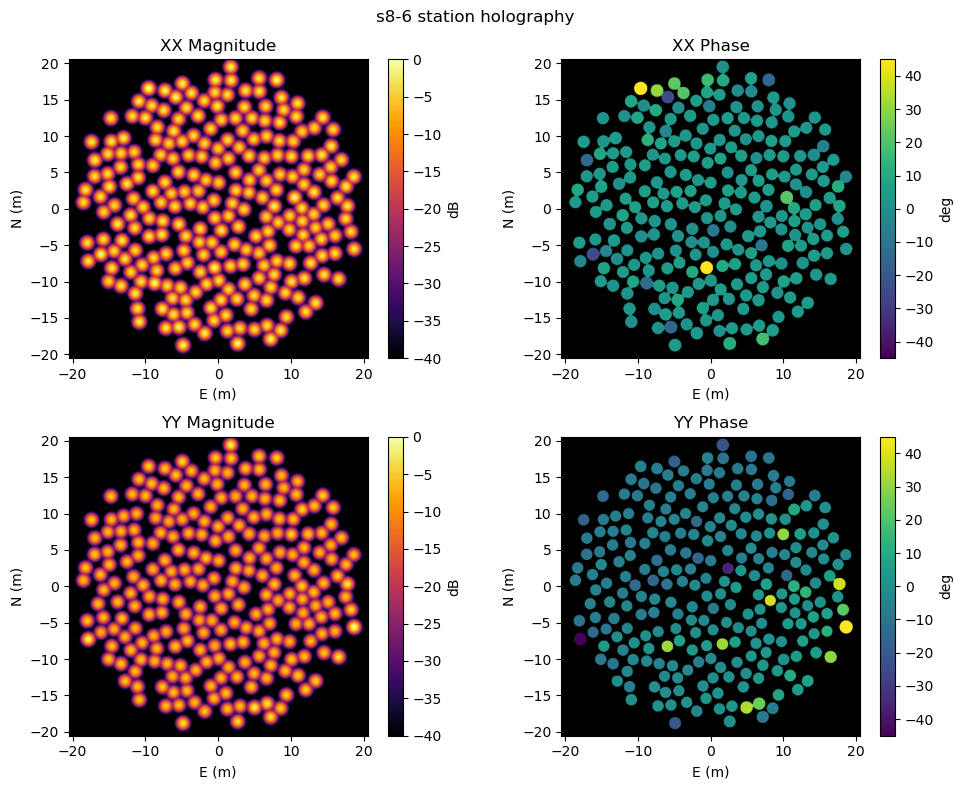

In [13]:
aa.calibration.holography.plot_aperture_xy(phs_range=(-45, 45))

## Make images

We can make images using the data (uncalibrated), calibrated data, and simulated data.

In [136]:
model_vis = aa.simulation.sim_vis_gsm()

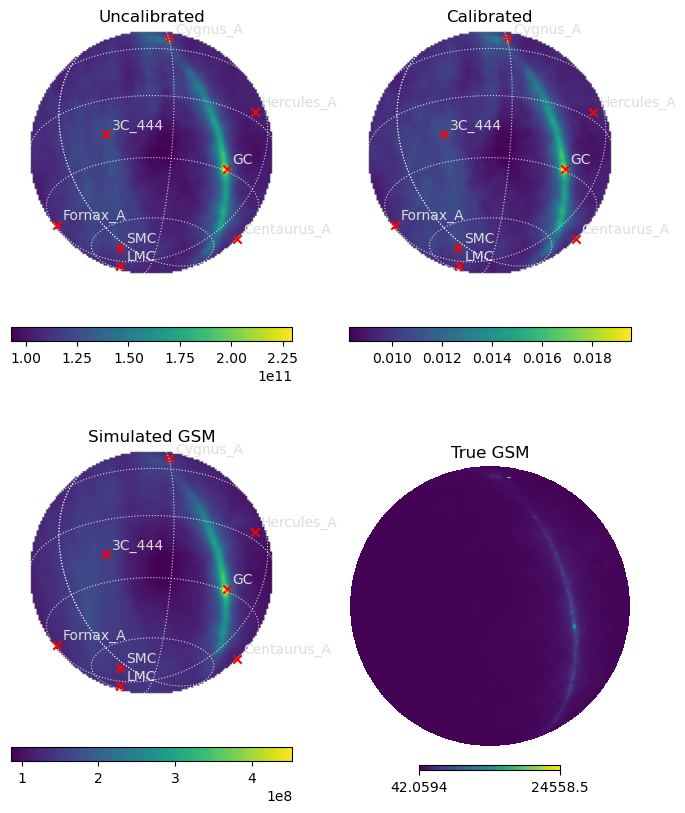

In [ ]:
plt.figure(figsize=(8, 10))
img_data = aa.imaging.make_image(vis='data')
aa.viewer.orthview(
    img_data, overlay_srcs=True, colorbar=True, title='Uncalibrated', subplot_id=(2, 2, 1), reuse_fig=True
)

img_cal = aa.imaging.make_image(vis='cal')
aa.viewer.orthview(
    img_cal, overlay_srcs=True, colorbar=True, title='Calibrated', subplot_id=(2, 2, 2), reuse_fig=True
)

# Run simulation to create model visibilities
model_vis = aa.simulation.sim_vis_gsm()
img_gsm = aa.imaging.make_image(vis='model')
aa.viewer.orthview(
    img_gsm, overlay_srcs=True, colorbar=True, title='Simulated GSM', subplot_id=(2, 2, 3), reuse_fig=True
)

# And show the true GSM (without generating visibilities)
plt.subplot(2, 2, 4)
aa.simulation.orthview_gsm(hold=True, title='True GSM')

## Compare data to model visibilities (GSM)

We should see a linear relationship between model visibilities and calibrated visibilities.

Note that here we did not use the model visibilities during cailbration (we just used the GC as a point source!).

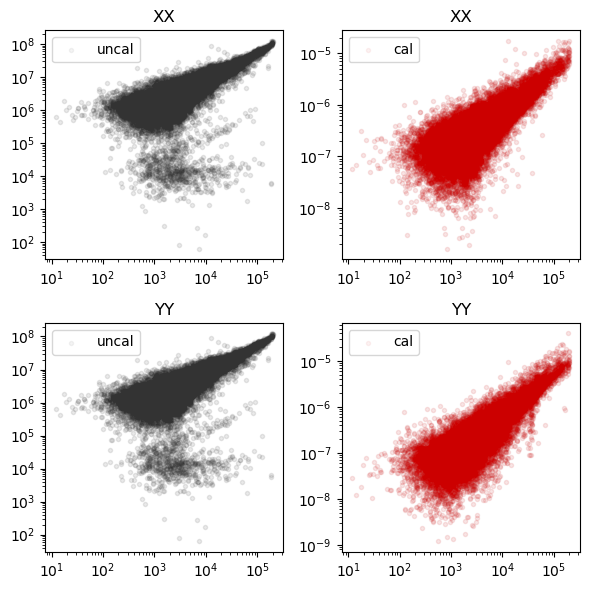

In [139]:
import numpy as np

plt.figure(figsize=(6, 6))

# Generate model visibilities from the GSM
model_vis = aa.simulation.sim_vis_gsm()

# Load data, model, and calibrated data.
V_data = aa.generate_vis_matrix('data')
V_model = aa.generate_vis_matrix('model')
V_cal = aa.generate_vis_matrix('cal')

# Blank autocorrelations
auto_idxs = np.diag_indices(256)
V_data[auto_idxs] = 0
V_model[auto_idxs] = 0
V_cal[auto_idxs] = 0

plt.subplot(2, 2, 1)
M = np.abs(V_model[..., 0]).flatten()
C = np.abs(V_cal[..., 0]).flatten()
D = np.abs(V_data[..., 0]).flatten()
plt.scatter(M, D, marker='.', alpha=0.05, color='#333333', label='uncal')
plt.legend()
plt.title('XX')
plt.loglog()

plt.subplot(2, 2, 2)
plt.scatter(M, C, marker='.', alpha=0.05, color='#cc0000', label='cal')
plt.legend()
plt.title('XX')
plt.loglog()

plt.subplot(2, 2, 3)
M = np.abs(V_model[..., 3]).flatten()
C = np.abs(V_cal[..., 3]).flatten()
plt.scatter(M, D, marker='.', alpha=0.05, color='#333333', label='uncal')
plt.legend()
plt.loglog()
plt.title('YY')

plt.subplot(2, 2, 4)
plt.scatter(M, C, marker='.', alpha=0.05, color='#cc0000', label='cal')
plt.legend()
plt.title('YY')
plt.loglog()
plt.tight_layout()